## Imports

In [1]:
import numpy as np
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D

import time
from numba import njit
from pyccel.epyccel import epyccel
from pyccel.decorators import types

## Pure python function

In [2]:
def solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu):
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for t in range(nt):
        # boundaries condition are included here since the initial vector is ones() 
        # and they're not changed anymore
        un[1:-1,1:-1] = u[1:-1,1:-1]
        vn[1:-1,1:-1] = v[1:-1,1:-1]
        for i in range(1,row-1):
                for j in range(1,col-1):
                    u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i-1,j])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy+nu*dt*((un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                    v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i-1,j])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy+nu*dt*((vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        
    return 0

## Numba accelerator

In [3]:
@njit(fastmath=True)
def solve_2d_burger_numba(u, un, v, vn, nt, dt, dx, dy, nu):
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for t in range(nt):
        # boundaries condition are included here since the initial vector is ones() 
        # and they're not changed anymore
        un[1:-1,1:-1] = u[1:-1,1:-1]
        vn[1:-1,1:-1] = v[1:-1,1:-1]
        for i in range(1,row-1):
                for j in range(1,col-1):
                    u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i-1,j])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy+nu*dt*((un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                    v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i-1,j])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy+nu*dt*((vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        
        
    return 0

## Pyccel accelerator

In [4]:
@types('float[:,:]','float[:,:]','float[:,:]','float[:,:]','int','float','float','float','float')
def solve_2d_burger_pyccel(u, un, v, vn, nt, dt, dx, dy, nu):
    
    ###Assign initial conditions
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    u[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2 
    ##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
    v[int(.5 / dy):int(1 / dy + 1),int(.5 / dx):int(1 / dx + 1)] = 2
    row, col = u.shape
    
    #fill the update of u and v
    for t in range(nt):
        # boundaries condition are included here since the initial vector is ones() 
        # and they're not changed anymore
        un[1:-1,1:-1] = u[1:-1,1:-1]
        vn[1:-1,1:-1] = v[1:-1,1:-1]
        for i in range(1,row-1):
                for j in range(1,col-1):
                    u[i,j]=un[i,j]-un[i,j]*dt*(un[i,j]-un[i-1,j])/dx-vn[i,j]*dt*(un[i,j]-un[i,j-1])/dy+nu*dt*((un[i+1,j]-2*un[i,j]+un[i-1,j])/dx**2+(un[i,j+1]-2*un[i,j]+un[i,j-1])/dy**2)
                    v[i,j]=vn[i,j]-un[i,j]*dt*(vn[i,j]-vn[i-1,j])/dx-vn[i,j]*dt*(vn[i,j]-vn[i,j-1])/dy+nu*dt*((vn[i+1,j]-2*vn[i,j]+vn[i-1,j])/dx**2+(vn[i,j+1]-2*vn[i,j]+vn[i,j-1])/dy**2)
        
    return 0

## Inputs

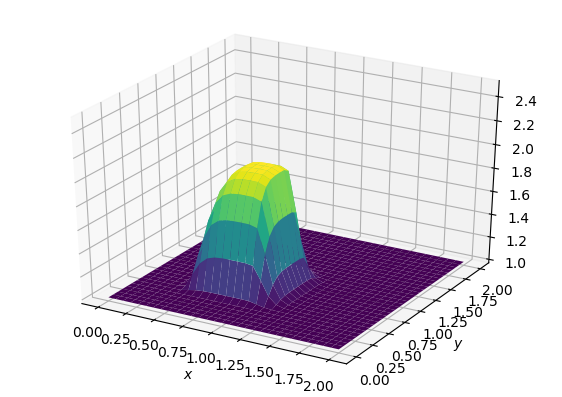

In [5]:
###variable declarations
nx = 31
ny = 31
nt = 120
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .0009
nu = 0.01
dt = sigma * dx * dy / nu


x = np.linspace(0, 2, nx)
y = np.linspace(0, 2, ny)

u = np.ones((ny, nx))  # create a 1xn vector of 1's
v = np.ones((ny, nx))
un = np.ones((ny, nx)) 
vn = np.ones((ny, nx))

solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu)

X, Y = np.meshgrid(x, y)
fig = pyplot.figure(figsize=(7, 5), dpi=100)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, u, rstride=1, cstride=1, cmap=cm.viridis, linewidth=0, antialiased=True)
ax.set_zlim(1, 2.5)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

## Call Funtions

### Pure function

In [6]:
%timeit solve_2d_burger_pure(u, un, v, vn, nt, dt, dx, dy, nu)

1.05 s ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with numba accelerator

In [7]:
%timeit solve_2d_burger_numba(u, un, v, vn, nt, dt, dx, dy, nu)

834 µs ± 76.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Function with pyccel accelerator

In [8]:
solve_2d_burger_f90 = epyccel(solve_2d_burger_pyccel)

In [9]:
%timeit solve_2d_burger_f90(u, un, v, vn, nt, dt, dx, dy, nu)

1.83 ms ± 2.35 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
